## CS156 Assignment 3 - Yosemite Village yearly weather

In [1]:
#importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from datetime import datetime
import pandas as pd
from sklearn.metrics.pairwise import rbf_kernel
from sklearn import metrics
from datetime import datetime
from mpl_toolkits.mplot3d.axes3d import Axes3D
%matplotlib notebook 


## Data Analysis
I first start by cleaning the data and turning it into the form (day, time) as mentioned in the assignment instructions.

In [2]:
years = range(2011, 2017) # all the 6 years
files = ['CRNS0101-05-%d-CA_Yosemite_Village_12_W.txt' % y for y in years] #names of the files that contain data
columns = [1, 2, 8] #the columns we need: 1: date, 2: time of day, 8: temperature

Loading the data for the six years using the specific columns mentioned in the cell above:

In [3]:
year_1 = np.loadtxt(files[0], usecols=columns)
#
year_2 = np.loadtxt(files[1], usecols=columns)
#
year_3 = np.loadtxt(files[2], usecols=columns)
#
year_4 = np.loadtxt(files[3], usecols=columns)
#
year_5 = np.loadtxt(files[4], usecols=columns)
#
year_6 = np.loadtxt(files[5], usecols=columns)

The time of the data is given in the form HHmm (HourHourminutesminutes), I convert it to minutes at 5 minutes step using the formula: **int((time)/100) * 60 + time%100**.
 Also, the missing data has values -1000 for temperature, I delete them here:

In [4]:
year_1[:, 1] = np.floor_divide(year_1[:, 1], 100) * 60 + np.mod(year_1[:, 1], 100)
year_1 = year_1[year_1[:, 2] > -1000] 

year_2[:, 1] = np.floor_divide(year_2[:, 1], 100) * 60 + np.mod(year_2[:, 1], 100)
year_2 = year_2[year_2[:, 2] > -1000] 

year_3[:, 1] = np.floor_divide(year_3[:, 1], 100) * 60 + np.mod(year_3[:, 1], 100)
year_3 = year_3[year_3[:, 2] > -1000] 

year_4[:, 1] = np.floor_divide(year_4[:, 1], 100) * 60 + np.mod(year_4[:, 1], 100)
year_4 = year_4[year_4[:, 2] > -1000]  

year_5[:, 1] = np.floor_divide(year_5[:, 1], 100) * 60 + np.mod(year_5[:, 1], 100)
year_5 = year_5[year_5[:, 2] > -1000] 

year_6[:, 1] = np.floor_divide(year_6[:, 1], 100) * 60 + np.mod(year_6[:, 1], 100)
year_6 = year_6[year_6[:, 2] > -1000]  

Now, I put the training data together (the first five years) and test data will be year 6:

In [5]:
# train data:
train_years = [year_1, year_2, year_3, year_4, year_5]
all_data_train = np.concatenate(train_years)

# test data:
all_data_test = year_6

I will get the full date just for reference

In [6]:
full_date = [] 
for s in all_data_train[:, 0]:
    s = str(s) # date as integer in the format "YearMonthDay"
    # the following line will take that string and put it in the form year-month-day
    full_date.append(str(datetime(year=int(s[0:4]), month=int(s[4:6]), day=int(s[6:8])).date()))

Now, I will build a dataset that has which day of the year each date refers to and which time of the day it refers to

In [7]:
# get the day of the year:
train_day_of_year = []

## For train data:
for year in train_years:
    for s in year[:, 0]:
        # putting the date in the datetime string form as mentioned above:
        s = str(s)   
        my_date = datetime(year=int(s[0:4]), month=int(s[4:6]), day=int(s[6:8])).date()
        day = my_date.timetuple().tm_yday # this is a method in Python's datetime module that returns
        #which day of the year that date refers to
        train_day_of_year.append(day)
        
## For test data: Doing the same for the test data
test_day_of_year = []
for s in all_data_test[:, 0]:
    s = str(s)   
    my_date = datetime(year=int(s[0:4]), month=int(s[4:6]), day=int(s[6:8])).date()
    day = my_date.timetuple().tm_yday
    test_day_of_year.append(day)
    

    
#time of the day:
# for train
train_time_of_day = all_data_train[:, 1] #in minutes
train_temperature = all_data_train[:, 2]

# For test:
test_time_of_day = all_data_test[:, 1] #in minutes
test_temperature = all_data_test[:, 2]


In [8]:
# finally, building the dataset:
train_DataFrame = pd.DataFrame({"Full Date": full_date,"Day Of the Year":train_day_of_year, 
                                "Minutes of the Day": train_time_of_day, "Temperature": train_temperature})
train_DataFrame

,Full Date,Day Of the Year,Minutes of the Day,Temperature
0,2011-01-01,1,5.0,-6.4
1,2011-01-01,1,10.0,-6.5
2,2011-01-01,1,15.0,-6.5
3,2011-01-01,1,20.0,-6.5
4,2011-01-01,1,25.0,-6.7
...,...,...,...,...
525475,2015-12-31,365,1420.0,-1.4
525476,2015-12-31,365,1425.0,-1.6
525477,2015-12-31,365,1430.0,-1.4
525478,2015-12-31,365,1435.0,-1.6


## Using RBF and fitting linear paramter models
In this section, I will use radial basis functions to enrich the representation of the x values (the time) for the yearly component, the daily component, and finally for two of them. I will use these representation to build linear models that predicts the temperature.

In [9]:
# turning the data into numpy array to map to the RBFs functions:

# train data:
train_day_of_year = np.array(train_day_of_year).reshape(-1, 1)
train_time_of_day = np.array(train_time_of_day).reshape(-1, 1)
train_temperature = train_temperature.reshape(-1, 1)

# test data:
test_day_of_year = np.array(test_day_of_year).reshape(-1, 1)
test_time_of_day = np.array(test_time_of_day).reshape(-1, 1)
test_temperature = test_temperature.reshape(-1, 1)


Starting with the yearly component of the data, I used 16 RBFs with a sigma value (width) of 81000. These values were obtained by experimenting different values until I get the best value of R_squared. I deleted the exploratory code as requested.

In [10]:
# The yearly component of the data:

# For train_data
RBFs_number = 16

# These are the centers for the RBFs. I will have 16 centers that are equally distributed between
# the minimum value of the day of the year (which is 1) and the maximum value (which is 365):

train_day_of_year_centers = np.array([i for i in range(int(min(train_day_of_year))
                                                       ,int(max(train_day_of_year))
                                                       ,int(max(train_day_of_year)-min(train_day_of_year)) \
                                                       //RBFs_number)]).reshape(-1, 1)

sigma = 81000 #width of RBFs

# mapping to the RBFs:
train_day_of_year_kernel = rbf_kernel(train_day_of_year, train_day_of_year_centers, gamma=1 / sigma)


######## Doing the same for the test data:

# For test_data:
RBFs_number = 16
test_day_of_year_centers = np.array([i for i in range(int(min(test_day_of_year))
                                                       ,int(max(test_day_of_year))
                                                       ,int(max(test_day_of_year)-min(test_day_of_year)) \
                                                       //RBFs_number)]).reshape(-1, 1)
sigma = 81000
test_day_of_year_kernel = rbf_kernel(test_day_of_year, test_day_of_year_centers, gamma=1 / sigma)


Now after I obtained a richer representation of the yearly component (my x-axis), I can use it to fit a linear model and predict the temperature (my y-axis):

In [11]:
model_linear_yearly = linear_model.LinearRegression() # using SKlearn's linear regression model
model_linear_yearly.fit(train_day_of_year_kernel, train_temperature) #fitting the model
predict_y_train_yearly = model_linear_yearly.predict(train_day_of_year_kernel) #using the model to predict

print(f"R_squared on train: {model_linear_yearly.score(train_day_of_year_kernel,train_temperature )}")
print(f"MAE on train: {metrics.mean_absolute_error(train_temperature, predict_y_train_yearly)}")

R_squared on train: 0.5695704946130584
MAE on train: 4.146294580357521


I can now make a plot to see how the model fitted the yearly data:

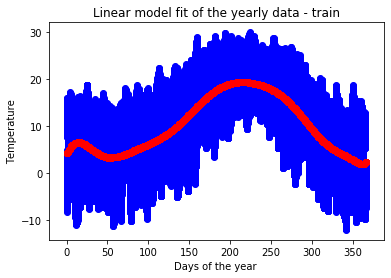

In [12]:
plt.scatter(train_day_of_year, train_temperature, color = 'blue')
plt.scatter(train_day_of_year, predict_y_train_yearly, color = 'red')
plt.xlabel("Days of the year ")
plt.ylabel('Temperature')
plt.title("Linear model fit of the yearly data - train")
plt.show()

Now, I can use the model to do prediction on the test data:

In [13]:
predict_y_test_yearly = model_linear_yearly.predict(test_day_of_year_kernel)

print(f"R_squared on test: {model_linear_yearly.score(test_day_of_year_kernel,test_temperature )}")
print(f"MAE on test: {metrics.mean_absolute_error(test_temperature, predict_y_test_yearly)}")

R_squared on test: 0.5712091734338828
MAE on test: 4.196997877336165


Again, I can plot and see how the model predicts the test data

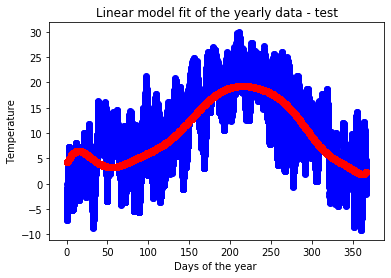

In [14]:
plt.scatter(test_day_of_year, test_temperature, color = 'blue')
plt.scatter(test_day_of_year, predict_y_test_yearly, color = 'red')
plt.xlabel("Days of the year ")
plt.ylabel('Temperature')
plt.title("Linear model fit of the yearly data - test")
plt.show()

Now, I'm going to repeat the same steps but for the daily data

In [15]:
# The daily component of the data:

# For train data:
RBFs_number = 16
train_time_of_day_centers = np.array([i for i in range(int(min(train_time_of_day))
                                                       ,int(max(train_time_of_day))
                                                       ,int(max(train_time_of_day)-min(train_time_of_day)) \
                                                       //RBFs_number)]).reshape(-1, 1)
sigma = 8000
train_time_of_day_kernel = rbf_kernel(train_time_of_day, train_time_of_day_centers, gamma=1 / sigma)



#######
# For test data:
RBFs_number = 16
test_time_of_day_centers = np.array([i for i in range(int(min(test_time_of_day))
                                                       ,int(max(test_time_of_day))
                                                       ,int(max(test_time_of_day)-min(test_time_of_day)) \
                                                       //RBFs_number)]).reshape(-1, 1)
sigma = 8000
test_time_of_day_kernel = rbf_kernel(test_time_of_day, test_time_of_day_centers, gamma=1 / sigma)

In [16]:
# Training the model using the daily component of the data:

model_linear_daily = linear_model.LinearRegression()
model_linear_daily.fit(train_time_of_day_kernel, train_temperature)
predict_y_train_daily = model_linear_daily.predict(train_time_of_day_kernel)

print(f"R_squared on train: {model_linear_daily.score(train_time_of_day_kernel,train_temperature )}")
print(f"MAE on train: {metrics.mean_absolute_error(train_temperature, predict_y_train_daily)}")

R_squared on train: 0.044505307841139485
MAE on train: 6.378514813905458


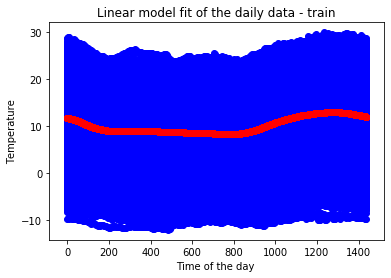

In [17]:
plt.scatter(train_time_of_day, train_temperature, color = 'blue')
plt.scatter(train_time_of_day, predict_y_train_daily, color = 'red')
plt.xlabel("Time of the day ")
plt.ylabel('Temperature')
plt.title("Linear model fit of the daily data - train")
plt.show()

In [18]:
# Using the model on the test data:

predict_y_test_daily = model_linear_daily.predict(test_time_of_day_kernel)

print(f"R_squared on test: {model_linear_daily.score(test_time_of_day_kernel,test_temperature )}")
print(f"MAE on test: {metrics.mean_absolute_error(test_temperature, predict_y_test_daily)}")

R_squared on test: 0.04428441247239845
MAE on test: 6.396436380529507


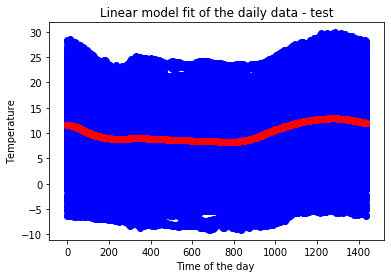

In [19]:
plt.scatter(test_time_of_day, test_temperature, color = 'blue')
plt.scatter(test_time_of_day, predict_y_test_daily, color = 'red')
plt.xlabel("Time of the day ")
plt.ylabel('Temperature')
plt.title("Linear model fit of the daily data - test")
plt.show()

Finally, I can now train a model with the two components and see how that will improve the R_squared value

In [20]:
# Merging the two componenets:
train_two_components_kernel = np.concatenate((train_day_of_year_kernel, train_time_of_day_kernel), axis=1)
test_two_components_kernel = np.concatenate((test_day_of_year_kernel, test_time_of_day_kernel), axis=1)

In [21]:
# Training the model using the two components of the data:

model_linear_two_components = linear_model.LinearRegression()
model_linear_two_components.fit(train_two_components_kernel, train_temperature)
predict_y_train_two_components = model_linear_two_components.predict(train_two_components_kernel)

print(f"R_squared on train: {model_linear_two_components.score(train_two_components_kernel,train_temperature )}")
print(f"MAE on train: {metrics.mean_absolute_error(train_temperature, predict_y_train_two_components)}")

R_squared on train: 0.6140601299054522
MAE on train: 3.9043302011474563


Plotting a 3D plot of the data

<IPython.core.display.Javascript object>


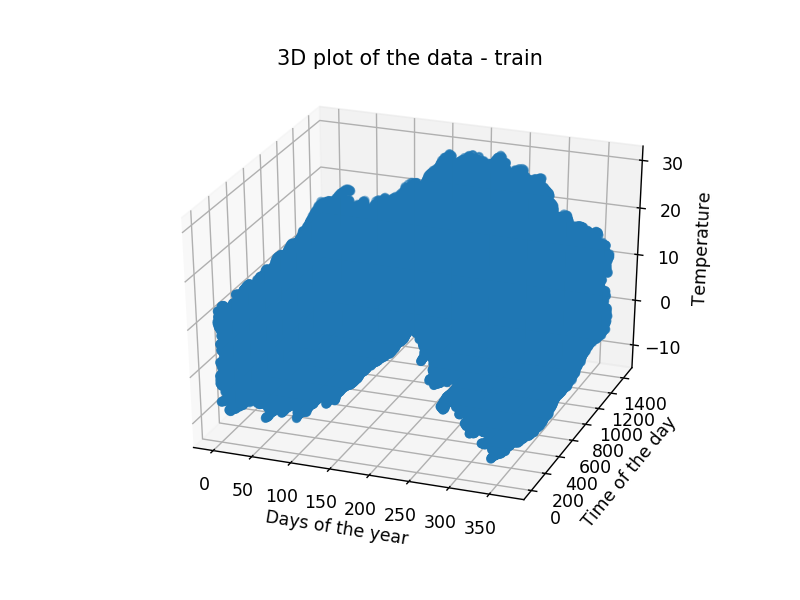

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(train_day_of_year, train_time_of_day, train_temperature)
ax.set_xlabel('Days of the year')
ax.set_ylabel('Time of the day')
ax.set_zlabel('Temperature')
plt.title("3D plot of the data - train", y=1.08)
plt.show()

Using the model to do prediction on the test data

In [23]:
predict_y_test_two_components = model_linear_two_components.predict(test_two_components_kernel)

print(f"R_squared on test: {model_linear_two_components.score(test_two_components_kernel,test_temperature )}")
print(f"MAE on test: {metrics.mean_absolute_error(test_temperature, predict_y_test_two_components)}")

R_squared on test: 0.6154190990761825
MAE on test: 3.9837408111580044


Finally, plotting a 3D plot to see how the model fits the data

<IPython.core.display.Javascript object>


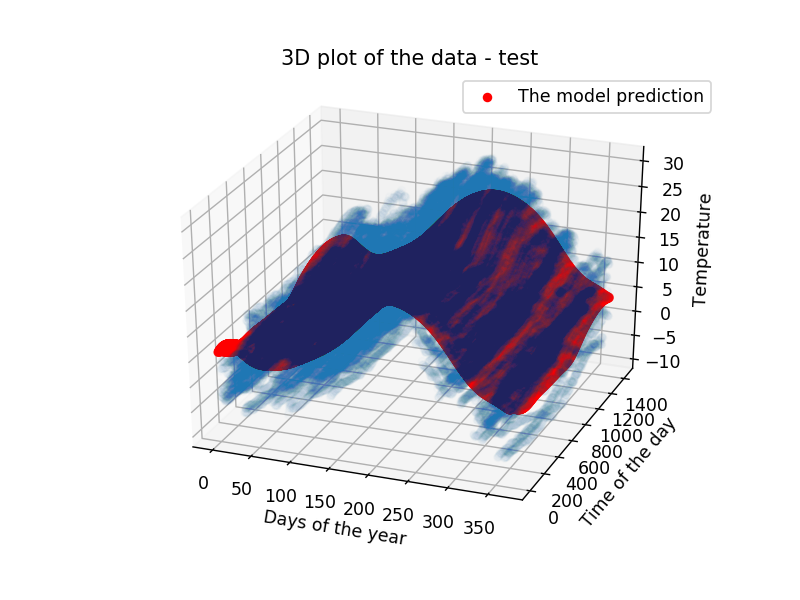

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(test_day_of_year, test_time_of_day, test_temperature, alpha = .01)
ax.scatter(test_day_of_year, test_time_of_day, predict_y_test_two_components, color = 'red', 
           label = 'The model prediction')

ax.set_xlabel('Days of the year')
ax.set_ylabel('Time of the day')
ax.set_zlabel('Temperature')
plt.title("3D plot of the data - test", y=1.08)
plt.legend()
plt.show()

### Conclusion
We saw from the analysis above that when we train the model using the daily component of the data only, we get R_squared value of 0.044 and mean absolute value of 6.4 (note that I'm using mean absolute value because it's insensitive to outliers  and this data has outliers(some times of the year that are exceptionally hotter or colder than usual). When I trained the model with the yearly component, I got R_squared of 0.57 and MAE of 4.14 which is a big improvement from using the daily data only. This makes sense because most of the variation in temperature is due to seasonal change (summer vs winter) that's why the model trained with yearly data should give a better R_squared (it covers more variance). Finally, when I trained the model using the two components, I got the best results: R_squared of 0.614 and MAE of 3.904.